In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
%matplotlib inline

Using TensorFlow backend.


In [2]:
model = ResNet50(weights='imagenet')

In [3]:
def show_img(x):
    plt.imshow(x[0].astype(int))
    plt.axis('off');

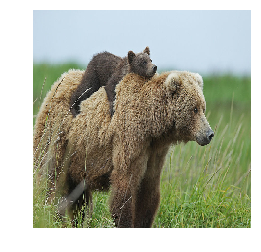

In [4]:
file = 'imgs/bear.jpg'
img = Image.open(file)
img_resized = img.resize((224, 224))
x = np.asarray(img_resized, np.float32)[None]
show_img(x)

Vamos a dividir la grilla en cuadrados y crear una funcion para ocultar aleatoriamente alguno de estos.

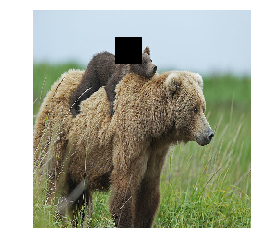

In [18]:
n_grids = 8

def create_occlusion(x, i, j, n_grids=8, fill=0):
    x = x.copy()
    grid_size = 224//n_grids
    x[0, i*grid_size:(i+1)*grid_size, j*grid_size:(j+1)*grid_size, :] = fill
    return x

def create_random_occlusion(x, n_grids=8):
    i, j = np.random.randint(0, n_grids, size=2)
    return create_occlusion(x, i, j, n_grids)
    
show_img(create_random_occlusion(x, n_grids))

Vamos a armar una matriz con todas las posibles oclusiones

In [6]:
occlusions = np.vstack([create_occlusion(x,i,j) for i in range(n_grids) for j in range(n_grids)])
occlusions = preprocess_input(occlusions)
occlusions.shape

(64, 224, 224, 3)

In [7]:
x_pre = preprocess_input(x.copy())
y_ = model.predict(x_pre)[0]
pred = np.argmax(y_)
real = np.eye(1000)[pred]

In [8]:
from sklearn.metrics import log_loss

baseline = log_loss(real, y_)
baseline

1.1106345625464087e-05

In [9]:
occlusions_y_ = model.predict(occlusions, verbose=1)

64/64 [==============================] - 14s 223ms/step


In [10]:
import pandas as pd

df = pd.DataFrame([(i,j) for i in range(n_grids) for j in range(n_grids)], columns=['i', 'j'])
df['imp'] = [log_loss(real, occlusions_y_[i]) - baseline for i in range(n_grids**2)]
df.imp -= df.imp.min()
df.imp /= df.imp.max()
df.head()

,i,j,imp
0,0,0,0.034382
1,0,1,0.040917
2,0,2,0.032944
3,0,3,0.016080
4,0,4,0.013615


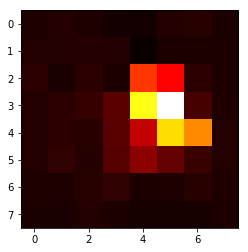

In [11]:
heatmap = np.zeros((1, n_grids, n_grids))

for i,row in df.iterrows():
    heatmap[0, int(row.i), int(row.j)] = row.imp
    
plt.imshow(heatmap[0], cmap='hot');

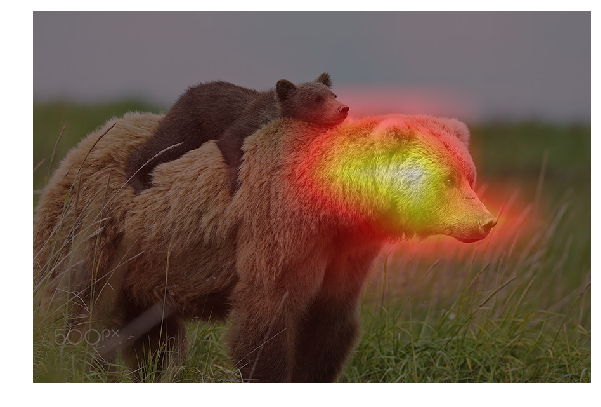

In [12]:
import cv2

heatmap = cv2.resize(heatmap[0], img.size)
plt.figure(figsize=(10,7))
plt.imshow(img)
plt.imshow(heatmap, cmap='hot', alpha=0.5)
plt.axis('off');

In [35]:
def explore_img(path, n_grids=8, figsize=(10,7)):
    # Load image
    img = Image.open(path)
    img_resized = img.resize((224, 224))
    x = np.asarray(img_resized, np.float32)[None]
    
    # Get occlusions
    occlusions = np.vstack([create_occlusion(x,i,j,n_grids) for i in range(n_grids) for j in range(n_grids)])
    occlusions = preprocess_input(occlusions)
    occlusions_y_ = model.predict(occlusions, verbose=1)
    
    # Get baseline
    x_pre = preprocess_input(x.copy())
    y_ = model.predict(x_pre)[0]
    pred = np.argmax(y_)
    labels = decode_predictions(y_[None])[0]
    real = np.eye(1000)[pred]
    baseline = log_loss(real, y_)
    
    # Build heatmap
    df = pd.DataFrame([(i,j) for i in range(n_grids) for j in range(n_grids)], columns=['i', 'j'])
    df['imp'] = [log_loss(real, occlusions_y_[i]) - baseline for i in range(n_grids**2)]
    df.imp -= df.imp.min()
    df.imp /= df.imp.max()
    heatmap = np.zeros((1, n_grids, n_grids))

    for i,row in df.iterrows():
        heatmap[0, int(row.i), int(row.j)] = row.imp

    heatmap = cv2.resize(heatmap[0], img.size)
    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.imshow(heatmap, cmap='hot', alpha=0.5)
    plt.axis('off')
    for e in labels: print(f'{e[1]}: {e[2]:.4f}')
    plt.show()


64/64 [==============================] - 13s 198ms/step
brown_bear: 0.9945
baboon: 0.0012
hyena: 0.0008
American_black_bear: 0.0007
bison: 0.0005


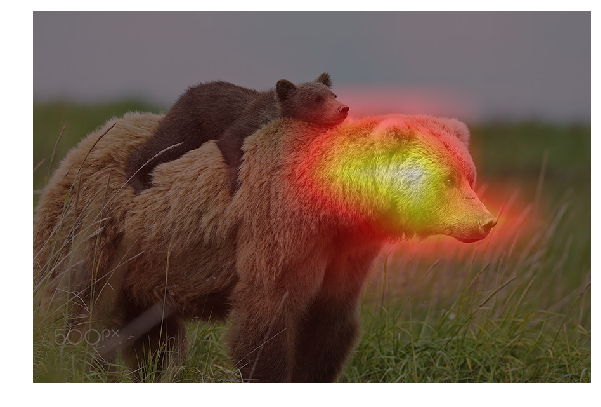

In [36]:
explore_img('imgs/bear.jpg')

64/64 [==============================] - 13s 198ms/step
tiger: 0.8458
tiger_cat: 0.1536
zebra: 0.0002
jaguar: 0.0001
lynx: 0.0001


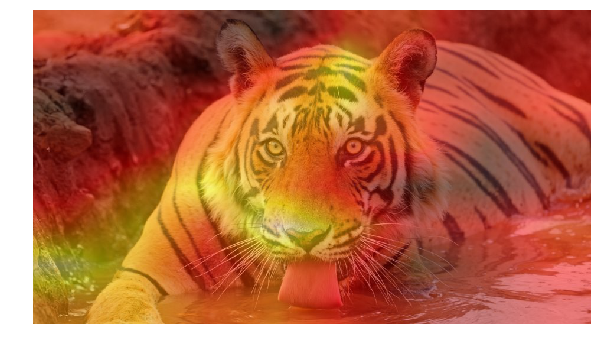

In [37]:
explore_img('imgs/tiger.jpg')

64/64 [==============================] - 13s 200ms/step
Appenzeller: 0.8900
Greater_Swiss_Mountain_dog: 0.0645
EntleBucher: 0.0137
Bernese_mountain_dog: 0.0106
basenji: 0.0096


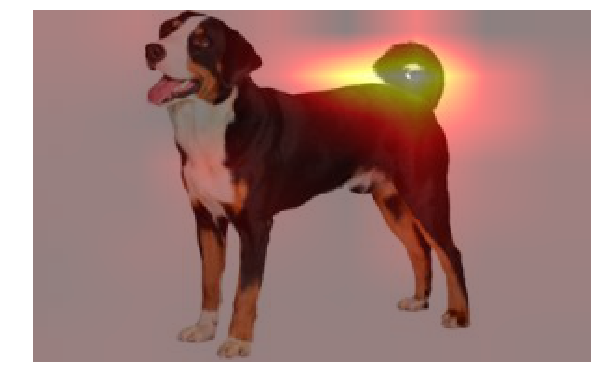

In [38]:
explore_img('imgs/dog1.jpg')

64/64 [==============================] - 13s 202ms/step
beagle: 0.7728
Walker_hound: 0.1762
English_foxhound: 0.0299
basset: 0.0192
bluetick: 0.0010


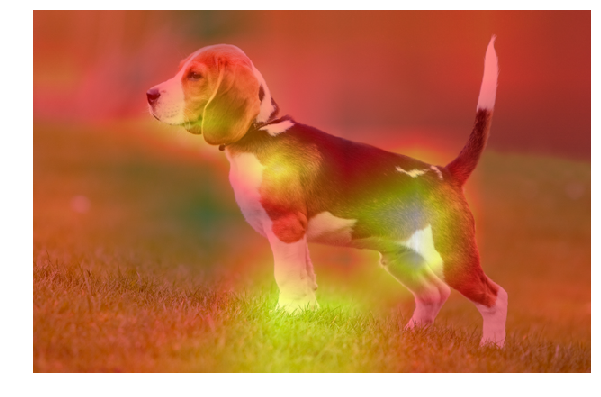

In [39]:
explore_img('imgs/dog2.jpg')

64/64 [==============================] - 14s 214ms/step
violin: 0.7266
cello: 0.2702
acoustic_guitar: 0.0005
holster: 0.0004
electric_guitar: 0.0004


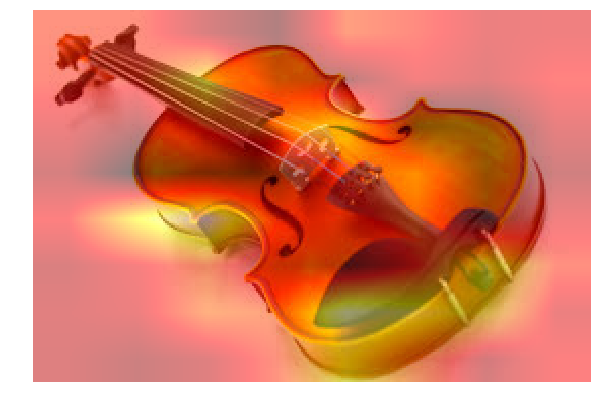

In [40]:
explore_img('imgs/violin.jpeg')